In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))


In [50]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

  Using cached pip-25.1.1-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-25.1.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\spsra\OneDrive\Desktop\ViT\venv311\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision

In [3]:
try:
  from torchinfo import summary
except:
  print(f"[INFO] torchinfo not found, installing....")
  !pip install -q torchinfo
  from torchinfo import summary

In [4]:
from torchvision import transforms
transform = transforms.Compose([
            transforms.Resize(size= (32, 32)),
            transforms.ToTensor()
])

In [5]:
from scripts.data_setup import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(transform=transform,
                   batch_size= 32
                   )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import gelu_cuda  

class CustomGELUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return gelu_cuda.gelu_forward(input.contiguous())

class CustomGELU(nn.Module):
    def forward(self, x):
        return CustomGELUFunction.apply(x)


In [6]:
train_features, train_labels = next(iter(train_dataloader))
train_features.shape, train_labels

(torch.Size([32, 3, 32, 32]),
 tensor([3, 1, 9, 8, 9, 1, 9, 9, 0, 4, 3, 0, 2, 0, 3, 2, 2, 1, 1, 7, 1, 8, 1, 5,
         6, 2, 0, 1, 5, 9, 9, 9]))

In [7]:
image, label = train_features[1], train_labels[1]
image.shape, label

(torch.Size([3, 32, 32]), tensor(1))

In [ ]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/109.0 kB ? eta -:--:--
     --- ------------------------------------ 10.2/109.0 kB ? eta -:--:--
     -------------------------------- ------ 92.2/109.0 kB 1.0 MB/s eta 0:00:01
     ----------------------------------- -- 102.4/109.0 kB 1.2 MB/s eta 0:00:01
     ------------------------------------ 109.0/109.0 kB 790.4 kB/s eta 0:00:00
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 10.7 MB/s eta 0:00:01
   ---------- ----------------------------- 2.0/8.1 MB 18.6 MB/s eta 0:00:01
   ------------- -------------------------- 2.8/8.1 MB 17.7 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/8.1 MB 19.7 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.1 MB 15.5 MB/s eta 0:00:01
   -------------------- -----


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

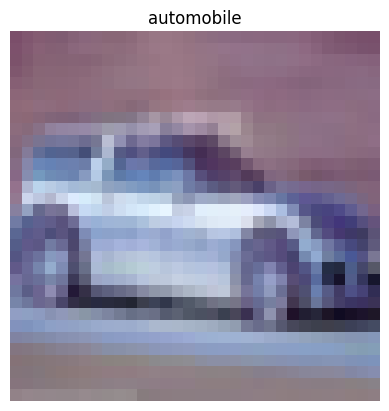

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [9]:
IMG_SIZE = 32
PATCH_SIZE = 4

assert IMG_SIZE % PATCH_SIZE == 0, "Image Size is not divisible by Patch Size"
number_of_patches = int((IMG_SIZE*IMG_SIZE) / PATCH_SIZE**2)

print(f"Number of Patches: {number_of_patches}")
embedding_output_layer = (1, number_of_patches, PATCH_SIZE**2 *3)
print("Embedding Input Layer: (1, 32, 32)")
print(f"Embedding Output Layer: {embedding_output_layer}")

Number of Patches: 64
Embedding Input Layer: (1, 32, 32)
Embedding Output Layer: (1, 64, 48)


In [10]:
image_permuted = image.permute(1, 2, 0)

Number of patches per row: 8.0
 Patch Size: 4 pixels by 4 pixels


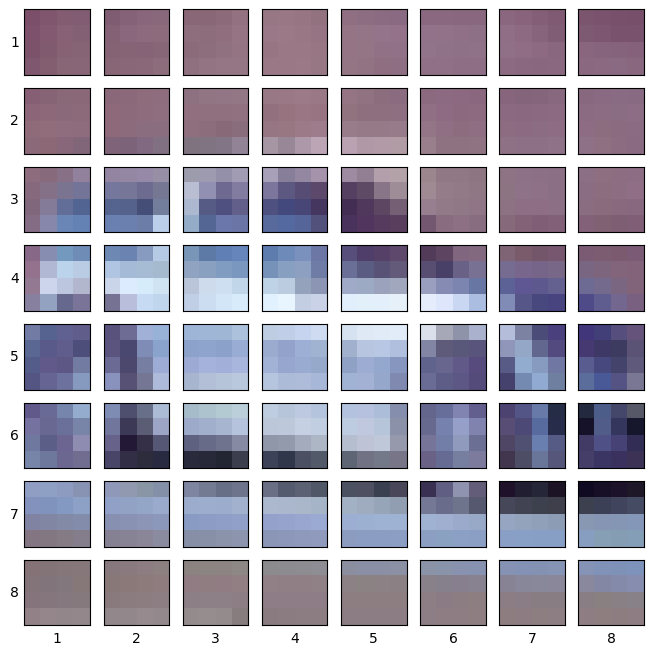

In [11]:
img_size = 32
patch_size = 4
num_patches = img_size / patch_size

assert img_size%patch_size == 0, "Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\n Patch Size: {patch_size} pixels by {patch_size} pixels")

fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols= img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex= True,
                        sharey= True)


for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size, patch_width:patch_width + patch_size, :])
    axs[i, j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

In [12]:
image.shape

torch.Size([3, 32, 32])

In [13]:
# Creating Patch and Position Embedding Layers

In [14]:
from torch import nn

In [15]:
class PatchEmbedding(torch.nn.Module):
  def __init__(self,
               in_channels:int = 3,
               embedding_dim:int = 128,
               patch_size= 4):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels= in_channels,
                             out_channels= embedding_dim,
                             kernel_size= patch_size,
                             stride= patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim = 2, end_dim = 3)

  def forward(self, x):
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0, 2, 1)

In [16]:
x = image.unsqueeze(dim = 0)
patch_embedding_layer = PatchEmbedding()
patch_embedding = patch_embedding_layer(x)
patch_embedding.shape

torch.Size([1, 64, 128])

In [17]:
batch_size = x.shape[0]
embedding_dim = 128
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token_embedding = torch.cat((class_token, patch_embedding), dim = 1)
class_token_embedding.shape

torch.Size([1, 65, 128])

In [18]:
num_of_patches = int((img_size*img_size)/patch_size**2)
position_embedding = nn.Parameter(torch.randn(batch_size, num_of_patches+1, embedding_dim),
                                  requires_grad= True)

position_and_patch_embedding = class_token_embedding + position_embedding
position_and_patch_embedding.shape

torch.Size([1, 65, 128])

In [19]:
single_flatten_image = position_embedding[:, :, 0]
plt.figure(figsize = (9, 9))
plt.axis(False)
plt.imshow(single_flatten_image.detach().numpy())

In [20]:
# Mulit-Head Attention

In [21]:
class MultiHeadSelfAttentionBlock(torch.nn.Module):
  def __init__(self,
               embedding_dim: int = 128,
               num_heads: int = 8,
               attn_dropout: float = 0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.msa_layer = nn.MultiheadAttention(embed_dim= embedding_dim,
                                           num_heads = num_heads,
                                           dropout= attn_dropout,
                                           batch_first= True)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.msa_layer(query = x,
                                    key= x,
                                    value= x,
                                    need_weights = False)
    return attn_output

In [22]:
msa_block = MultiHeadSelfAttentionBlock()
patched_image_through_msa = msa_block(position_and_patch_embedding)
patched_image_through_msa.shape

torch.Size([1, 65, 128])

In [ ]:
class MLPBlock(torch.nn.Module):
  def __init__(self,
               embedding_dim: int = 128,
               mlp_size:int = 128*4,
               mlp_dropout:float = 0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape= embedding_dim)

    self.mlp = nn.Sequential(
               nn.Linear(in_features = embedding_dim,
                         out_features = mlp_size),
               CustomGELU(),
               nn.Dropout(p=mlp_dropout),
               nn.Linear(in_features= mlp_size,
                         out_features= embedding_dim),
               nn.Dropout(p= mlp_dropout)
    )

  def forward(self, x):
    x= self.layer_norm(x)
    x = self.mlp(x)
    return x

In [24]:
mlp_block = MLPBlock()
patched_image_through_mlp = mlp_block(patched_image_through_msa)
patched_image_through_mlp.shape

torch.Size([1, 65, 128])

In [25]:
summary(model= mlp_block,
        input_size = (1, 65, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLPBlock (MLPBlock)                      [1, 65, 128]         [1, 65, 128]         --                   True
├─LayerNorm (layer_norm)                 [1, 65, 128]         [1, 65, 128]         256                  True
├─Sequential (mlp)                       [1, 65, 128]         [1, 65, 128]         --                   True
│    └─Linear (0)                        [1, 65, 128]         [1, 65, 512]         66,048               True
│    └─GELU (1)                          [1, 65, 512]         [1, 65, 512]         --                   --
│    └─Dropout (2)                       [1, 65, 512]         [1, 65, 512]         --                   --
│    └─Linear (3)                        [1, 65, 512]         [1, 65, 128]         65,664               True
│    └─Dropout (4)                       [1, 65, 128]         [1, 65, 128]         --                   --
Total params: 131,96

In [26]:
# creating Transformer Block

In [27]:
class TransformerEncoderBlock(torch.nn.Module):
  def __init__(self,
               embedding_dim:int = 128,
               num_heads:int = 8,
               attn_dropout:float = 0,
               mlp_size:int = 128*4,
               mlp_dropout:float = 0.1):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads= num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size= mlp_size,
                              mlp_dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [28]:
transformer_block = TransformerEncoderBlock()
patched_image_through_transformer_block = transformer_block(patched_image_through_mlp)
patched_image_through_transformer_block.shape

torch.Size([1, 65, 128])

In [29]:
summary(model= transformer_block,
        input_size = (1, 65, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 65, 128]         [1, 65, 128]         --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 65, 128]         [1, 65, 128]         --                   True
│    └─LayerNorm (layer_norm)                      [1, 65, 128]         [1, 65, 128]         256                  True
│    └─MultiheadAttention (msa_layer)              --                   [1, 65, 128]         66,048               True
├─MLPBlock (mlp_block)                             [1, 65, 128]         [1, 65, 128]         --                   True
│    └─LayerNorm (layer_norm)                      [1, 65, 128]         [1, 65, 128]         256                  True
│    └─Sequential (mlp)                            [1, 65, 128]         [1, 65, 128]         --                   True
│    │    └─Linear (0)                     

In [30]:
class ViT(torch.nn.Module):
  def __init__(self,
               img_size:int = 32,
               patch_size:int = 4,
               embedding_dim:int = 128,
               embedding_dropout:float = 0.1,
               in_channels:int = 3,
               num_heads:int = 8,
               attn_dropout:float = 0,
               mlp_size:int = 128*4,
               mlp_dropout:float = 0.1,
               num_transformer_layer:int = 8,
               num_class:int = 10):


      super().__init__()

      assert img_size % patch_size == 0, "Image Size is not divisible by Patch Size"

      self.num_of_patches = int((img_size*img_size) / patch_size**2)

      self.patch_embedding = PatchEmbedding(in_channels= in_channels,
                                            embedding_dim= embedding_dim,
                                            patch_size= patch_size)
      self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                      requires_grad= True)

      self.position_embedding = nn.Parameter(torch.randn(1, num_of_patches+1, embedding_dim),
                                             requires_grad= True)

      self.embedding_dropout = nn.Dropout(p= embedding_dropout)

      self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim= embedding_dim,
                                                                          num_heads= num_heads,
                                                                          attn_dropout= attn_dropout,
                                                                          mlp_size= mlp_size,
                                                                          mlp_dropout= mlp_dropout) for _ in range(num_transformer_layer)])

      self.classifier = nn.Sequential(
                        nn.LayerNorm(normalized_shape= embedding_dim),
                        nn.Linear(in_features= embedding_dim,
                                  out_features= num_class)
      )

  def forward(self, x):
    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1)

    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim = 1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])

    return x

In [31]:
vit = ViT()

In [32]:
summary(model=vit,
        input_size=(32, 3, 32, 32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 32, 32]      [32, 10]             8,448                True
├─PatchEmbedding (patch_embedding)                      [32, 3, 32, 32]      [32, 64, 128]        --                   True
│    └─Conv2d (patcher)                                 [32, 3, 32, 32]      [32, 128, 8, 8]      6,272                True
│    └─Flatten (flatten)                                [32, 128, 8, 8]      [32, 128, 64]        --                   --
├─Dropout (embedding_dropout)                           [32, 65, 128]        [32, 65, 128]        --                   --
├─Sequential (transformer_encoder)                      [32, 65, 128]        [32, 65, 128]        --                   True
│    └─TransformerEncoderBlock (0)                      [32, 65, 128]        [32, 65, 128]        --                   True
│    │ 

In [33]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

12.1
True
1


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
vit = vit.to(device)
next(vit.parameters()).device

device(type='cuda', index=0)

In [ ]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
from scripts.engine import train

optimizer = torch.optim.AdamW(
    vit.parameters(),
    lr=3e-4,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)

loss_fn = torch.nn.CrossEntropyLoss()



results = train(model = vit,
                       train_dataloader= train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)

c:\Users\spsra\OneDrive\Desktop\ViT\venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:25<30:45, 205.04s/it]

Epoch: 1 | train_loss: 1.8965 | train_acc: 0.3020 | test_loss: 1.6579 | test_acc: 0.4097 | 


 20%|██        | 2/10 [06:48<27:10, 203.86s/it]

Epoch: 2 | train_loss: 1.5898 | train_acc: 0.4273 | test_loss: 1.4628 | test_acc: 0.4727 | 


 30%|███       | 3/10 [10:00<23:11, 198.84s/it]

Epoch: 3 | train_loss: 1.4566 | train_acc: 0.4760 | test_loss: 1.3484 | test_acc: 0.5170 | 


 40%|████      | 4/10 [13:18<19:50, 198.42s/it]

Epoch: 4 | train_loss: 1.3719 | train_acc: 0.5050 | test_loss: 1.3231 | test_acc: 0.5232 | 


 50%|█████     | 5/10 [17:00<17:14, 206.99s/it]

Epoch: 5 | train_loss: 1.3028 | train_acc: 0.5333 | test_loss: 1.2644 | test_acc: 0.5431 | 


 60%|██████    | 6/10 [19:59<13:08, 197.24s/it]

Epoch: 6 | train_loss: 1.2434 | train_acc: 0.5533 | test_loss: 1.2346 | test_acc: 0.5577 | 


 70%|███████   | 7/10 [23:19<09:55, 198.37s/it]

Epoch: 7 | train_loss: 1.1921 | train_acc: 0.5727 | test_loss: 1.1884 | test_acc: 0.5739 | 


 80%|████████  | 8/10 [28:23<07:43, 231.76s/it]

Epoch: 8 | train_loss: 1.1414 | train_acc: 0.5910 | test_loss: 1.1631 | test_acc: 0.5853 | 


 90%|█████████ | 9/10 [32:57<04:04, 244.95s/it]

Epoch: 9 | train_loss: 1.0967 | train_acc: 0.6075 | test_loss: 1.1388 | test_acc: 0.5941 | 


100%|██████████| 10/10 [37:19<00:00, 223.97s/it]

Epoch: 10 | train_loss: 1.0572 | train_acc: 0.6216 | test_loss: 1.1512 | test_acc: 0.5948 | 
